In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
df = pd.read_csv('/Users/velo1/SynologyDrive/GIT_syno/data/NLP/news.csv')
df.sort_values(by = ['event'], inplace = True)
df.head()

,Unnamed: 0,event,text
297,297,CNN показала фильм «Владимир Путин — самый вли...,CNN: ВЛАДИМИР ПУТИН - САМЫЙ МОГУЩЕСТВЕННЫЙ ЧЕ...
298,298,CNN показала фильм «Владимир Путин — самый вли...,"РБК (rbc.ru), Москва, 14 марта 2017 КРЕМЛЬ ПР..."
678,678,SpaceX впервые в истории запустила и посадила ...,"Newstes.ru, Москва, 31 марта 2017 ПОЛЕТ НОРМА..."
679,679,SpaceX впервые в истории запустила и посадила ...,"Vistanews.ru, Москва, 31 марта 2017 SPACE X В..."
680,680,SpaceX впервые в истории запустила и посадила ...,"Russia Today (russian.rt.com), Москва, 31 мар..."


In [3]:
df.event.value_counts()

Чемпионат мира по хоккею                                                                                    102
Власти Петербурга согласились передать РПЦ Исаакиевский собор.                                              100
Правительство внесло в Госдуму законопроект о курортных сборах                                              100
Единый день голосования                                                                                     100
Умер Евгений Евтушенко                                                                                      100
Кубок конфедерации FiFA                                                                                     100
теракт произошел в центре Лондона                                                                           100
Акции протеста 12 июня                                                                                      100
Митинг в москве против коррупции                                                                        

### Препроцессинг

In [4]:
import re
from nltk.corpus import stopwords

In [7]:
from pymystem3 import Mystem
mystem = Mystem()

In [6]:
!pip install pymorphy2

In [8]:
import pymorphy2
m = pymorphy2.MorphAnalyzer()

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/velo1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
mystopwords = stopwords.words('russian') + [
    'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д',
    'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой'
]
ru_words = re.compile("[А-Яа-я]+")


def words_only(text):
    return " ".join(ru_words.findall(text))


# def lemmatize(text, mystem=m):
#     try:
#         return "".join(m.lemmatize(text)).strip()  
#     except:
#         return " "

def lemmatize(text, mystem=m):
    try:
        return " ".join([m.parse(w)[0].normal_form for w in text.split(' ')]).strip()  
    except:
        return " "

def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

    
def preprocess(text):
    return remove_stopwords(lemmatize(words_only(text.lower())))

In [10]:
%%time
df.text = df.text.apply(preprocess)

CPU times: user 12.7 s, sys: 40.8 ms, total: 12.7 s
Wall time: 12.7 s


## Генсим

### TfidfModel

In [11]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities

In [12]:
texts = [text.split() for text in df.text]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [13]:
# поизучаем, что здесь происходит
# corpus

Косинусная близость:


$$similarity=\cos(\theta )={\mathbf {A} \cdot \mathbf {B}  \over \|\mathbf {A} \|\|\mathbf {B} \|}={\frac {\sum \limits _{i=1}^{n}{A_{i}B_{i}}}{{\sqrt {\sum \limits _{i=1}^{n}{A_{i}^{2}}}}{\sqrt {\sum \limits _{i=1}^{n}{B_{i}^{2}}}}}}$$

Вычисление сходства по косинусной мере на векторах $tf-idf$:

In [14]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [15]:
corpus_tfidf

In [16]:
# %%time
index = similarities.MatrixSimilarity(corpus_tfidf)
sims = index[corpus_tfidf]

In [17]:
len(corpus)

1930

In [18]:
sims[0]

array([1.0000001 , 0.38914615, 0.01390167, ..., 0.0498321 , 0.01490081,
       0.00640168], dtype=float32)

In [19]:
sims.shape

(1930, 1930)

In [20]:
import seaborn as sns

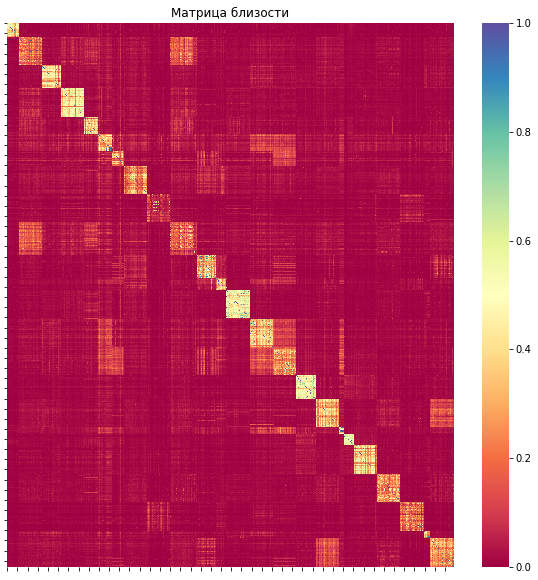

In [21]:
plt.figure(figsize = (10,10))
sns.heatmap(data=sims, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])
plt.title("Матрица близости")
plt.show()

### Латентно-семантический анализ (LSA, LSI)


Сингулярное разложение: $M'_k = U \Sigma_k V^t_k$

* $M$ – матрица слово-документ
* $U$ – матрица документ-тема
* $k$ – число тем
* $V$ - матрица слово-тема

In [22]:
from gensim.models import lsimodel

In [23]:
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=30)

CPU times: user 3.28 s, sys: 545 ms, total: 3.83 s
Wall time: 1.74 s


In [24]:
lsi.show_topics(5)

[(0,
  '0.223*"путин" + 0.163*"трамп" + 0.147*"меркель" + 0.132*"президент" + 0.119*"курортный" + 0.115*"навальный" + 0.114*"акция" + 0.111*"теракт" + 0.106*"сбор" + 0.103*"собор"'),
 (1,
  '0.551*"курортный" + 0.468*"сбор" + 0.235*"законопроект" + 0.212*"эксперимент" + 0.159*"инфраструктура" + 0.148*"введение" + 0.128*"внести" + 0.119*"крым" + 0.119*"край" + 0.112*"алтайский"'),
 (2,
  '0.384*"собор" + 0.288*"исаакиевский" + -0.229*"путин" + 0.223*"передача" + 0.219*"рпц" + -0.212*"меркель" + 0.211*"акция" + -0.159*"трамп" + 0.150*"навальный" + 0.146*"петербург"'),
 (3,
  '-0.283*"теракт" + -0.240*"чуркин" + 0.236*"собор" + -0.220*"барселона" + -0.196*"евтушенко" + 0.180*"путин" + 0.179*"меркель" + 0.177*"исаакиевский" + -0.154*"виталий" + -0.149*"лондон"'),
 (4,
  '0.392*"чуркин" + 0.358*"евтушенко" + 0.251*"виталий" + 0.232*"поэт" + -0.212*"теракт" + 0.178*"евгений" + 0.158*"оон" + -0.156*"барселона" + 0.142*"умереть" + 0.130*"собор"')]

Как снижение размерности влияет на матрицу близости:

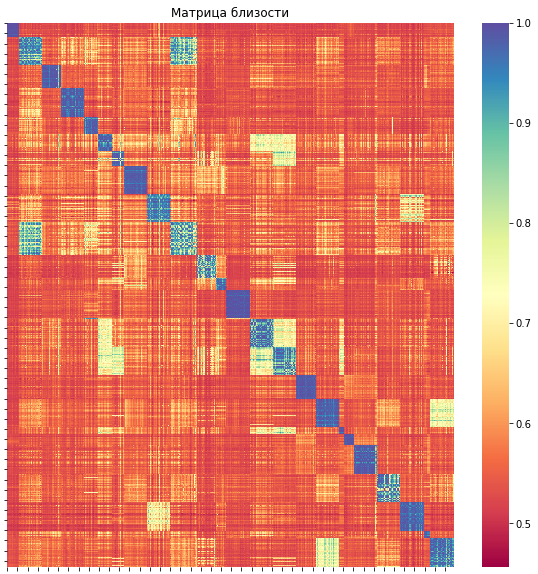

In [25]:
corpus_lsi = lsi[corpus]
index = similarities.MatrixSimilarity(lsi[corpus])
sims = index[corpus_lsi]
sims  = (sims + 1)/2.
plt.figure(figsize = (10,10))
sns.heatmap(data=sims, cmap = 'Spectral').set(xticklabels=[], yticklabels=[])
plt.title("Матрица близости")
plt.show()

### Главные компоненты

In [26]:
X = [0] * len(df)
Y = [0] * len(df)
for i in range(len(df)):
    vec = corpus[i]
    LSI_topics = (lsi[vec])
    for topic in LSI_topics:
        if topic[0] == 0:
            X[i] = topic[1]
        elif topic[0] == 1:
            Y[i] = topic[1]

vis_df = pd.DataFrame({'X': X, 'Y': Y, 'topic' : df.event})

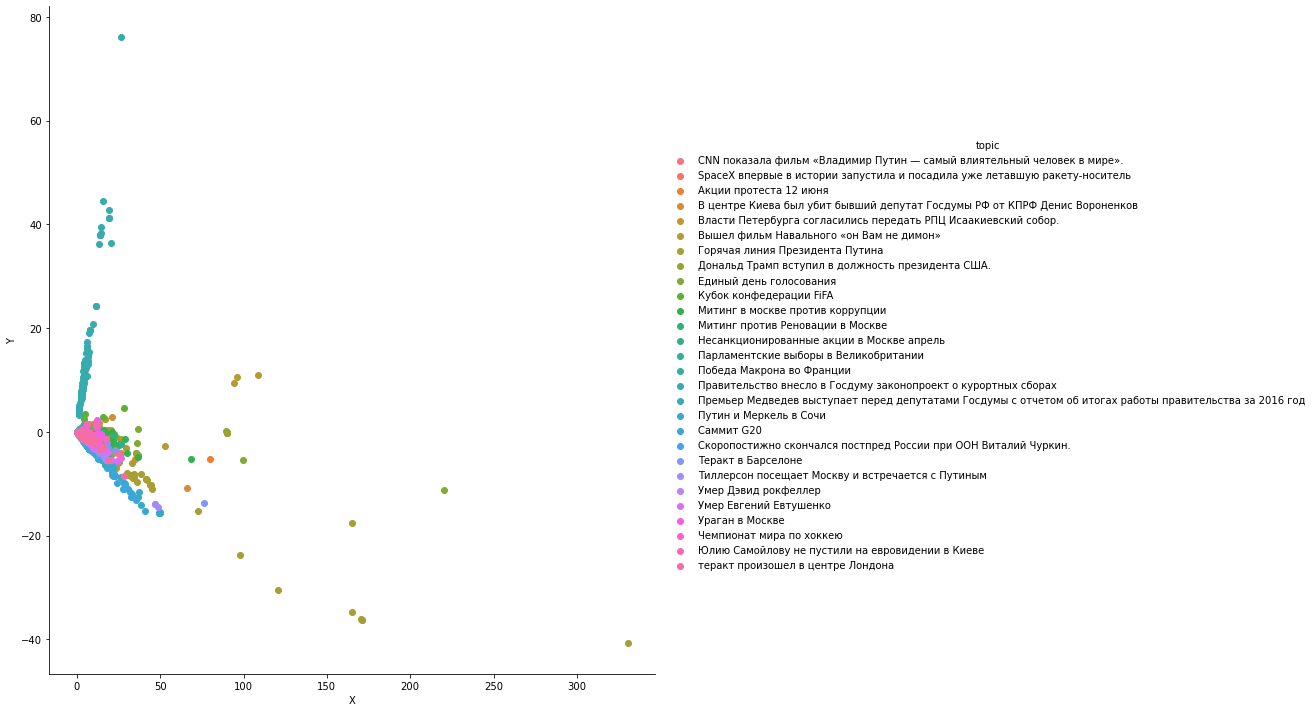

In [27]:
sns.FacetGrid(vis_df, hue="topic", size = 10).map(plt.scatter, "X", "Y").add_legend()

### Truncated SVD и TSNE

#### t-SNE
t-SNE (t-distributed Stochastic Neighbor Embedding) — техника нелинейного снижения размерности и визуализации многомерных переменных. Она разработана специально для данных высокой размерности Л. ван дер Маатеном и Д. Хинтоном. 

t-SNE — это итеративный алгоритм, основанный на вычислении попарных расстояний между всеми объектами (в том числе поэтому он довольно медленный).

In [28]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
vectors = TfidfVectorizer().fit_transform(df.text) # строим тф-идф матрицу документ-слово
X_reduced = TruncatedSVD(n_components=5, random_state=0).fit_transform(vectors) # оставляем n главных компонент

In [30]:
X_reduced

array([[ 0.34074418, -0.15041378,  0.09414658,  0.02356228, -0.00349209],
       [ 0.27019855, -0.10536249,  0.05667868,  0.00888222,  0.00899628],
       [ 0.07153188, -0.00070265, -0.00528504, -0.00908877,  0.02879732],
       ...,
       [ 0.24465772,  0.01820507, -0.15149728, -0.22736268, -0.12115712],
       [ 0.19083422,  0.10197917, -0.20530564, -0.27933019, -0.1586554 ],
       [ 0.16115503,  0.08633544, -0.17375482, -0.18076363, -0.1061458 ]])

In [31]:
# %%time
X_embedded = TSNE(n_components=2, perplexity=5, verbose=0).fit_transform(X_reduced) # строим мэппинг в двухмерную плоскость с TSNE

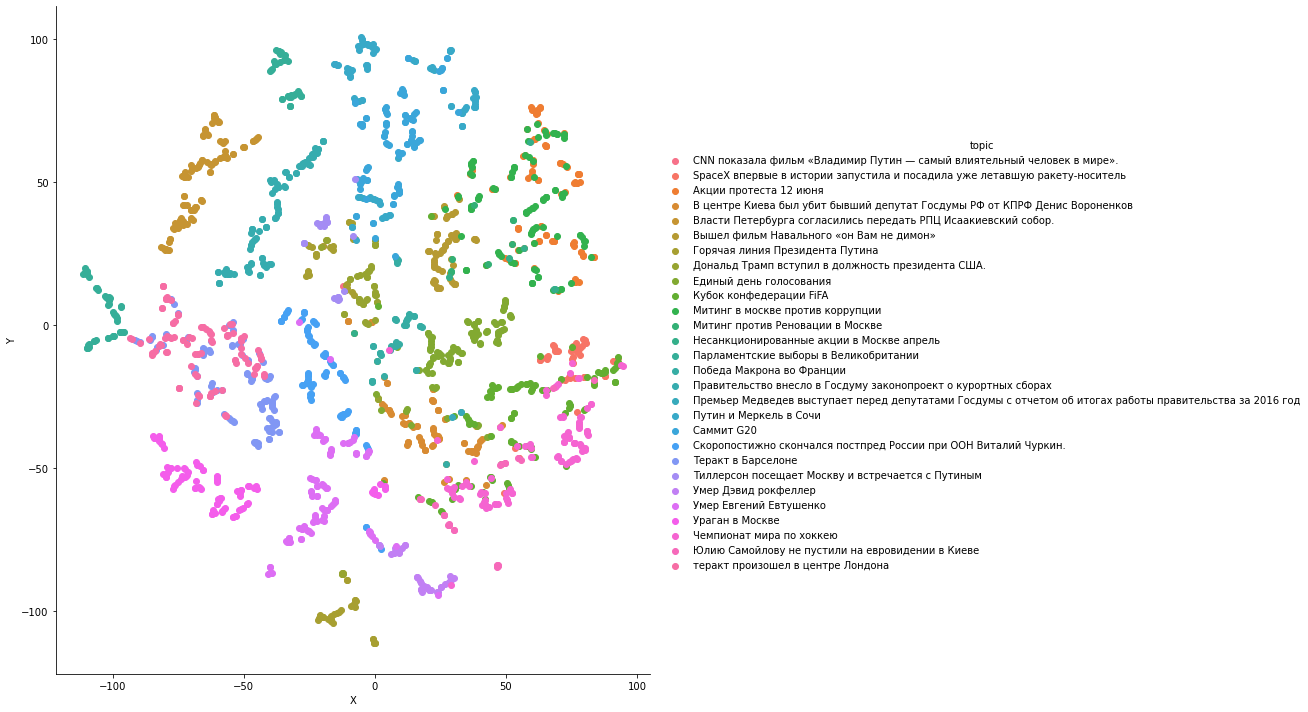

In [32]:
vis_df = pd.DataFrame({'X': X_embedded[:, 0], 'Y': X_embedded[:, 1], 'topic' : df.event})
sns.FacetGrid(vis_df, hue="topic", size=10).map(plt.scatter, "X", "Y").add_legend()